# CH-315 – Modeling Lab
## GroupC_Block1 – **Part C: Simulation / Modeling** (Skeleton)

**Contributors:** Fatima Abdoun and Serena Bou Chaaya

> This notebook is a scaffold for Part C only. Replace TODOs with your work and add explanations in Markdown. Keep code modular and well-documented.


---
## C.1 Monte Carlo π estimation (Person A)
Implement a function `estimate_pi(N)` that samples `N` points uniformly in the square [-1, 1] × [-1, 1], counts how many fall inside the unit circle, and returns the estimate of π.

**Deliverables:**
1. `estimate_pi(N)` function.
2. Convergence plot of π estimate vs. N .
3. Short Markdown discussion of accuracy and variance.


In [1]:

import numpy as np
import matplotlib.pyplot as plt

def estimate_pi(N: int, rng=None) -> float:
    """
    Estimate π by Monte Carlo using N random points in [-1,1] × [-1,1].

    Parameters
    ----------
    N : int
        Number of random points.
    rng : np.random.Generator or None
        Random generator to use. If None, uses np.random.default_rng().

    Returns
    -------
    float
        π estimate.
    """
    if rng is None:
        rng = np.random.default_rng()
    x = rng.uniform(-1, 1, size=N)
    y = rng.uniform(-1, 1, size=N)
    inside = (x*x + y*y) <= 1
    return 4.0 * inside.mean()



In [2]:
for N in [100, 1000, 10000, 100000]:
    print(N, estimate_pi(N))

100 3.12
1000 3.188
10000 3.1456
100000 3.13768


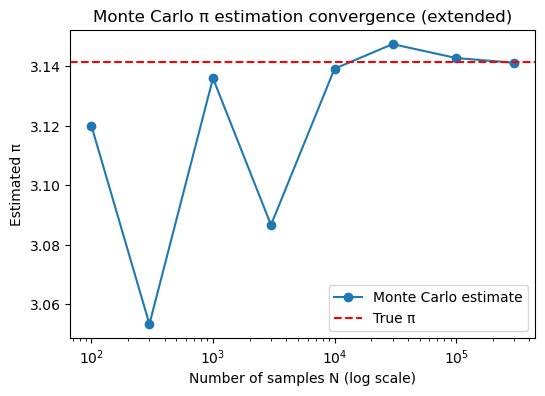

In [3]:
Ns = [100, 300, 1000, 3000, 10000, 30000, 100000, 300000]
pi_estimates = [estimate_pi(N) for N in Ns]

plt.figure(figsize=(6,4))
plt.plot(Ns, pi_estimates, marker='o', label='Monte Carlo estimate')
plt.axhline(np.pi, color='r', linestyle='--', label='True π')
plt.xscale('log')
plt.xlabel('Number of samples N (log scale)')
plt.ylabel('Estimated π')
plt.title('Monte Carlo π estimation convergence (extended)')
plt.legend()
plt.show()


### C.1 – Discussion

The convergence plot shows that the Monte Carlo estimate of π fluctuates a lot for small values of N. This is because random noise dominates when the number of samples is low, which leads to large deviations from the true value. At N = 1000–3000, the estimate can overshoot or undershoot π significantly.

As N increases, the estimates stabilize and approach the true value of π. This is an illustration of the Law of Large Numbers: as the number of random samples grows, the average result converges to the expected probability.

The error decreases approximately as $1/\sqrt{N}$, meaning that to improve precision by one decimal place, about 100 times more samples are needed. This trade-off highlights both the power and the cost of Monte Carlo methods: they are easy to implement and generalize, but require many samples for high accuracy.




---
## C.2 Chemistry-inspired Monte Carlo
Simulate random molecular collisions in a box, assign energies (from a chosen distribution), and estimate the **reaction probability** as the fraction of collisions exceeding a threshold energy.

**Deliverables:**
1. Functions to generate energies and compute the fraction above a threshold.
2. Experiments varying `M` and the threshold `E_thresh` (and optionally the distribution parameters).
3. Plots (histogram of energies; probability vs threshold) and a short discussion linking to chemistry.


In [4]:

import numpy as np
import matplotlib.pyplot as plt

def simulate_collision_energies(M: int, dist: str = 'normal', rng=None, **kwargs) -> np.ndarray:
    """
    Generate M non-negative collision energies.

    Parameters
    ----------
    M : int
        Number of simulated collisions.
    dist : {"exponential", "uniform", "normal"}
        Distribution family for energies.
    rng : np.random.Generator or None
        Random generator for reproducibility (default: np.random.default_rng()).

    Optional kwargs by distribution
    -------------------------------
    exponential: scale (float, mean energy; default 2.0)
    uniform    : low, high (floats; default 0.0, 10.0)
    normal     : mean, std (floats; default 5.0, 2.0)  # will be clipped to >= 0

    Returns
    -------
    np.ndarray of shape (M,)
    """
    if rng is None:
        rng = np.random.default_rng()

    if dist == "exponential":
        scale = kwargs.get("scale", 2.0)
        E = rng.exponential(scale, size=M)

    elif dist == "uniform":
        low  = kwargs.get("low", 0.0)
        high = kwargs.get("high", 10.0)
        E = rng.uniform(low, high, size=M)

    elif dist == "normal":
        mean = kwargs.get("mean", 5.0)
        std  = kwargs.get("std",  2.0)
        E = rng.normal(mean, std, size=M)
        E = np.clip(E, 0.0, None)  # energies must be non-negative

    else:
        raise ValueError("dist must be one of: 'exponential', 'uniform', 'normal'.")

    return E

   

def reaction_probability(energies: np.ndarray, E_thresh: float) -> float:
    """
    Estimate reaction probability as fraction of energies >= E_thresh.
    """
    return float(np.count_nonzero(energies >= E_thresh)) / energies.size

def binom_ci_95(p_hat: float, n: int):
    """
    95% normal-approx confidence interval for a binomial proportion.
    """
    se = np.sqrt(max(p_hat*(1 - p_hat), 1e-12) / n)
    return (p_hat - 1.96*se, p_hat + 1.96*se)
  


p_hat = 0.6721  (95% CI: [0.6692, 0.6750])


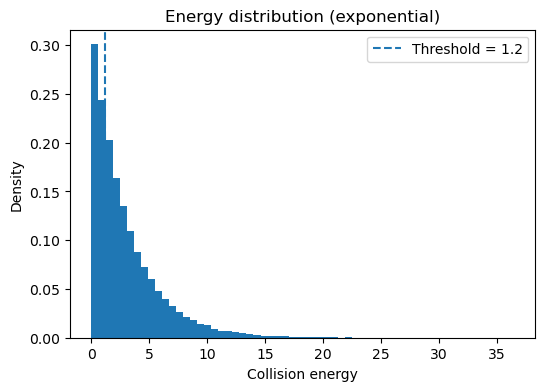

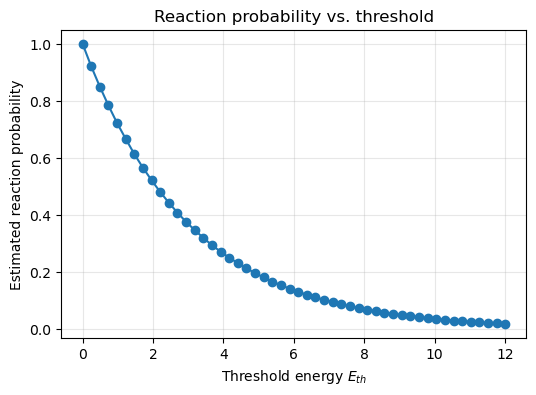

In [5]:
# C.2 – Example experiment template 
M = 100_000  # number of collisions
E_thresh = 1.2

# TODO: choose distribution and parameters
dist = "exponential"          # pick family: "exponential"/"uniform"/"normal"
dist_params = dict(scale=3.0) # parameters for that family (here: mean=3.0)
# alternatives:
# dist_params = dict(low=0.0, high=12.0)
# dist_params = dict(mean=5.0, std=2.0)

rng = np.random.default_rng(42)                           # fixed seed = reproducible
E = simulate_collision_energies(M, dist=dist, rng=rng, **dist_params)

# estimate probability + CI
p_hat = reaction_probability(E, E_thresh)                 # fraction ≥ threshold
ci = binom_ci_95(p_hat, M)                                # 95% CI
print(f"p_hat = {p_hat:.4f}  (95% CI: [{ci[0]:.4f}, {ci[1]:.4f}])")

# Plot histogram of energies

plt.figure(figsize=(6,4))                                 # create figure
plt.hist(E, bins=60, density=True)                        # normalized histogram
plt.axvline(E_thresh, linestyle="--", label=f"Threshold = {E_thresh}")  # vertical line
plt.xlabel("Collision energy")
plt.ylabel("Density")
plt.title(f"Energy distribution ({dist})")
plt.legend()
plt.show()  

# TODO: add a sweep over E_thresh and plot probability vs threshold

E_thresh_values = np.linspace(0.0, 12.0, 50)   # 50 thresholds from 0 to 12

p_vals = []
for thr in E_thresh_values:
    p_vals.append(reaction_probability(E, thr))  # reuse same energies; vary threshold

plt.figure(figsize=(6,4))
plt.plot(E_thresh_values, p_vals, marker="o")    # probability curve
plt.xlabel("Threshold energy $E_{th}$")
plt.ylabel("Estimated reaction probability")
plt.title("Reaction probability vs. threshold")
plt.grid(True, alpha=0.3)
plt.show()

#### C.2 – Discussion

* **Model.** Each collision gets an energy $E$ from the chosen distribution (we used *exponential* with mean = 3 unless noted).
* **Reaction criterion.** Reaction occurs if $E \ge E_{th}$. The estimator is $\hat p = k/M$ with $k$ successes.
* **Uncertainty.** Approximate 95% CI: $\hat p \pm 1.96\sqrt{\hat p(1-\hat p)/M}$.
* **Observations.** As $M$ increases, variance shrinks and $\hat p$ stabilizes. Increasing $E_{th}$ lowers the reaction probability; the curve’s shape depends on the assumed energy distribution (physics intuition: higher activation energy → rarer events).
* **Chemistry link.** This mirrors the idea of activation energy: at fixed temperature (energy distribution), only a fraction of collisions have enough energy to react.


---
## Joint conclusions – Comparing C.1 and C.2 
Summarize similarities/differences between the two Monte Carlo problems (geometry vs. energy threshold; estimator variance; convergence with sample size; interpretation in chemistry).